<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/9A_Q1_Set2_downsampling_preprocessing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook, word vectors in addition to the lexeme strings and word features derived in previous notebooks are used as a feature set.

Dataset is downsamples for balanced class weights. 

After, the  features are joined to the main Q1 training set.

The same preprocessing pipeline will be used to transform the Q1test set. 

This will make both datasets ready for modeling. 

Since larger dimensions are being dealt with, high-RAM option is selected:

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



Importing libraries and mounting google drive:

In [ ]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Q1 train set:

In [ ]:
q1train = decompress_pickle(path_name+"Q1TRAIN.pbz2") 

In [ ]:
q1train.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
7,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:07:12,5.143600,1.000000
15,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:08:50,0.000891,1.000000
20,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,18.921030,0.888889
21,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,0.714286
22,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,1.000000


Downsampling to reasonable size:

In [ ]:
# creating dataframe from sparse matrix
df = q1train.drop('p_forgot_bin',axis=1)
# combining with y
df['y'] = q1train['p_forgot_bin']

# nsplitting sparse dataframe by class values
df0 = df[df['y']==0]
df1 = df[df['y']==1]

# number of positive samples
numdf1 = df1.shape[0]

# what fraction of df0 do we need to equal the numbers of df1?
fractiondf0 = numdf1/df0.shape[0]

# sampling from negative class samples to get only the fraction needed 
df0_ = df0.sample(frac = fractiondf0,random_state = 15)

# recombine and shuffle downsampled negative samples df0_ and all of positive samples df1:
df_downsampled = pd.concat([df0_, df1],axis=0).sample(frac=1,random_state=20)

df_downsampled = df_downsampled.sample(frac=0.5,random_state=25)

In [ ]:
# create the sparse matrices ready for training
q1trainy = df_downsampled['y']
q1trainX = df_downsampled.drop('y',axis=1)

q1trainX['p_forgot_bin'] = q1trainy
q1train = q1trainX

In [ ]:
q1trainX.shape

(1319735, 17)

In [ ]:
q1trainy.sum()/q1trainy.shape[0]

0.49990566287929017

To recap, above is a quick look at the contents of Q1TRAIN, the main dataframe. 


Loading Q1 test set:

In [ ]:
q1test = decompress_pickle(path_name+"Q1TEST.pbz2")

In [ ]:
q1test.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
23,1362082274,444649,u:dDwF,es,en,4bdb859f599fa07dd5eecdab0acc2d34,a/a<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,5.146400,1.000000
26,1362082274,678813,u:dDwF,es,en,64f2b1bdc5c91bb3f6ca1bb7a808b60a,quieres/querer<vblex><pri><p2><sg>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,7.856632,1.000000
30,1362082274,8562343,u:dDwF,es,en,edf5a0ef6c836c4df4f3b3de76ca63ba,diario/diario<n><m><sg>,3,3,3,3,0,0.000159,"(en, es)",2013-02-28 20:11:14,99.101192,1.000000
41,1362082274,6645723,u:dDwF,es,en,c2c8a202a12411858f87d4dcef5b2998,no/no<adv>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,76.918090,1.000000
50,1362082274,7239420,u:dDwF,es,en,81fe07635e2aa79cd36709cf1bdd81be,limón/limón<n><m><sg>,3,2,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,83.789583,0.666667


Confirming the shapes:

In [ ]:
q1train.shape, q1test.shape

((1319735, 17), (1795528, 17))

In [ ]:
q1train.size/10**6, q1test.size/10**6

(22.435495, 30.523976)

List of lexeme ids in q1train dataframe:

In [ ]:
q1train_lexemelist = q1train['lexeme_id'].unique()

In [ ]:
all_lexemes = decompress_pickle(path_name+"Duolingo_all_lexemes.pbz2")

In [ ]:
all_lexemes.shape

(19279, 17)

Filtering to only the words in the training set 

In [ ]:
q1trainlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1train_lexemelist),:]

In [ ]:
q1trainlexemes.columns, q1trainlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (9580, 17))

Filtering out test set lexemes dataframe for transformation:

In [ ]:
q1test_lexemelist = q1test['lexeme_id'].unique()
q1testlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1test_lexemelist),:]

In [ ]:
q1testlexemes.shape

(2776, 17)

Getting wordvectors.

In [ ]:
wordvecs = decompress_pickle(path_name+"Duolingo_wordvectors.pbz2")

In [ ]:
wordvecs.head()

,lexeme_id,vectorlist
0,76390c1350a8dac31186187e2fe1e178,"[-0.12485239869, 0.403838020553, -0.3502961037..."
1,7dfd7086f3671685e2cf1c1da72796d7,"[0.0432688036856, -0.0914570974226, -0.1884847..."
2,35a54c25a2cda8127343f6a82e6f6b7d,"[-0.0895643525954, 0.208577167333, -0.06067782..."
3,0cf63ffe3dda158bc3dbd55682b355ae,"[0.0156379608103, 0.37910027723, -0.2013124868..."
4,84920990d78044db53c1b012f5bf9ab5,"[0.0388741864242, 0.160898776301, -0.105828861..."


The vectors are currently contained in a single column holding numpy arrays. 
There are also some null values

In [ ]:
wordvecs.isna().sum()

lexeme_id       0
vectorlist    176
dtype: int64

In [ ]:
176/wordvecs.shape[0]*100

0.9129104206649722

Almost 1% of the vectors are null. 
They will be imputed within the train and test splits. 

In [ ]:
q1trainvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q1train_lexemelist),:]

# for non-na values
notna = q1trainvecs.loc[~q1trainvecs['vectorlist'].isna(),:]
q1trainvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# computing centroid for imputation of nulls 
q1trainvecs_centroid = q1trainvecs_notna_expanded.mean(axis=0)

# separating out null valued rows
is_na = q1trainvecs.loc[q1trainvecs['vectorlist'].isna(),:]
is_na.index = is_na['lexeme_id']

numnulls = is_na.shape[0]

# imputing with centroid
q1trainvecs_na_expanded = pd.concat([pd.DataFrame(q1trainvecs_centroid).transpose()]*numnulls,axis=0)
q1trainvecs_na_expanded.index = is_na.index

# joining imputed null with the rest, keeping index consistent
q1trainvecs_expanded = pd.concat([q1trainvecs_na_expanded,q1trainvecs_notna_expanded],axis=0)

# viewing first few rows:
q1trainvecs_expanded.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
5377c84560aaf45988067be11302d1d8,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
eca9cad5e0a5d96f5db19271e2e3e122,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
5d09ea8ec2581f32fbfd1ce09fc21221,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
26133676f75f829992c823dd7402f9a3,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
276598aa526cf531bf27a78173452baf,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246


The first few rows contain the now imputed with centroid rows.

The wordvectors are combined with the train lexemes set to make feature set 2. 

In [ ]:
q1trainvecs = pd.merge(left = q1trainlexemes, right = q1trainvecs_expanded, how = "left",left_on = 'lexeme_id',right_index = True)
q1trainvecs.shape

(9580, 317)

The rest of the preprocessing is similar to that done in feature set 1: 
one-hot-encoding the language, part of speech and modifiers. 

A look at the current columns of q1trainlexemes:

In [ ]:
q1trainlexemes = q1trainvecs
q1trainlexemes.columns

Index([        'lexeme_id', 'learning_language',     'lexeme_string',
            'surface_form',        'lemma_form',               'pos',
              'modstrings',         'sf_length',    'sf_translation',
          'lf_translation',
       ...
                       290,                 291,                 292,
                       293,                 294,                 295,
                       296,                 297,                 298,
                       299],
      dtype='object', length=317)

At this point, Test set word vectors are prepared in the same way.

The centroid computed above frmo the train set is used to impute missing vectors in the test set. 

In [ ]:
q1testvecs = wordvecs.loc[wordvecs['lexeme_id'].isin(q1test_lexemelist),:]

# for non-na values, expanding the vectorlist columns so that one value is in one column: 
notna = q1testvecs.loc[~q1testvecs['vectorlist'].isna(),:]
q1testvecs_notna_expanded = pd.DataFrame(notna['vectorlist'].tolist(),index = notna['lexeme_id'])


# separating the null valued vectors
is_na = q1testvecs.loc[q1testvecs['vectorlist'].isna(),:]
numnulls = is_na.shape[0]
print(numnulls)
is_na.index = is_na['lexeme_id']

# imputing null valued vector rows with centroid
q1testvecs_na_expanded = pd.concat([pd.DataFrame(q1trainvecs_centroid).transpose()]*numnulls,axis=0)
q1testvecs_na_expanded.index = is_na.index

q1testvecs_expanded = pd.concat([q1testvecs_na_expanded,q1testvecs_notna_expanded],axis=0)

# look at the first few rows:
q1testvecs_expanded.head()

19


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lexeme_id,,,,,,,,,,,,,,,,,,,,,
3baca3559289e14345edc0c53f516033,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
883996f36cc186da5983b13384230a9f,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
fc1b93172eef30156a0b8c388c72571c,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
0c7c00989ed4b87cc6e704712beec291,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246
a45c0dfd77553cf466546d8f42f2d34a,0.143007,0.168539,-0.171652,-0.0112,0.121196,0.002074,-0.018806,-0.072593,0.085114,1.221576,...,-0.154037,0.076133,-0.119719,-0.048785,-0.0055,-0.002385,-0.034318,0.013183,-0.071152,0.048246


Combining the test set expanded vectors with the q1testlexemes

In [ ]:
q1testvecs = pd.merge(left = q1testlexemes, right = q1testvecs_expanded, how = "left",left_on = 'lexeme_id',right_index = True)
q1testvecs.shape

(2776, 317)

In [ ]:
q1testlexemes = q1testvecs
q1testlexemes.columns

Index([        'lexeme_id', 'learning_language',     'lexeme_string',
            'surface_form',        'lemma_form',               'pos',
              'modstrings',         'sf_length',    'sf_translation',
          'lf_translation',
       ...
                       290,                 291,                 292,
                       293,                 294,                 295,
                       296,                 297,                 298,
                       299],
      dtype='object', length=317)

## <font color = 'cornflowerblue' size=4>Preprocessing and PCA</font>

### <font color = 'cornflowerblue' size=3>One hot encoding of categoricals</font>
The learning language, pos and mostrings are further converted to binary dummies: 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_lang = OneHotEncoder(sparse=False,handle_unknown='ignore')
enc_pos = OneHotEncoder(sparse = False,handle_unknown = 'ignore')
enc_mods = OneHotEncoder(sparse=False,handle_unknown='ignore')

# get one hot encoded learning language
enc_lang.fit(np.array(q1trainlexemes['learning_language']).reshape(-1, 1))
q1train_lang = pd.DataFrame(enc_lang.transform(np.array(q1trainlexemes['learning_language']).reshape(-1, 1)),index=q1trainlexemes.index)

# get one hot encoded part of speech:
enc_pos.fit(np.array(q1trainlexemes['pos']).reshape(-1, 1))
q1train_pos = pd.DataFrame(enc_pos.transform(np.array(q1trainlexemes['pos']).reshape(-1, 1)),index=q1trainlexemes.index)


In [ ]:
# get one hot encoded modstrings
q1trainlexemes['modstrings'].head()

7                []
20          [m, pl]
21    [pri, p1, sg]
22          [m, sg]
24    [pri, p3, sg]
Name: modstrings, dtype: object

Since modstrings are saved as a list of strings, some more processing needs to be done before passing to the one hot encoder. 

In [ ]:
# explode values of list so a separate record is created for each element of the list. 
q1trainlexemes['modstrings'].explode()
enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1train_mods_exploded =enc_mods.transform(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))

q1train_modsdf_exploded = pd.DataFrame(q1train_mods_exploded, index = q1trainlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1train_modsdf = q1train_modsdf_exploded.groupby(q1train_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [ ]:
q1train_modsdf.shape, q1trainlexemes.shape

((9580, 84), (9580, 317))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [ ]:
q1trainlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']+list(range(0,300))].shape

(9580, 304)

In [ ]:
q1trainfeatureset2 = pd.concat([q1trainlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']+list(range(0,300))],
                                q1train_lang, 
                                q1train_pos, 
                                q1train_modsdf, 
                                ],axis=1)

In [ ]:
q1trainfeatureset2.shape

(9580, 464)

In [ ]:
q1trainfeatureset2.columns = ['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id'] + list(range(0,300)) + ['lang_'+c for c in list(enc_lang.get_feature_names_out())] + ['pos_' + c for c in list(enc_pos.get_feature_names_out())] + ['mod_' + c for c in list(enc_mods.get_feature_names_out())]

Checking if there are generated column names that are duplicates:

In [ ]:
len(list(q1trainfeatureset2.columns)) - len(set(q1trainfeatureset2.columns))

0

In [ ]:
q1trainfeatureset2.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,lexeme_id,0,1,2,3,4,5,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
7,4,0.5,3.733996,73eecb492ca758ddab5371cf7b5cca32,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,5,0.6,10.981924,c84476c460737d9fb905dca3d35ec995,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,3,0.0,4.051187,1a913f2ded424985b9c02d0436008511,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,5,0.8,0.438409,38b770e66595fea718366523b4f7db3f,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24,3,1.0,0.502649,faa6fd18132b358958e440322ee82b4b,0.129024,0.423030,-0.457697,0.013778,0.316385,0.414319,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The feature set has 466 columns, containing derived word features such as sf_length, EnglishIDF and the word vectors, followed by one-hot encoded values of the cateogorical columns provided in the duolingo dataset. 

Checking for any null values:

In [ ]:
q1trainfeatureset2.isna().sum()

sf_length                     0
L_dist_sf_noaccents_norm      0
EnglishIDF                  110
lexeme_id                     0
0                             0
                           ... 
mod_x0_sp                     0
mod_x0_subj                   0
mod_x0_sup                    0
mod_x0_tn                     0
mod_x0_nan                    0
Length: 464, dtype: int64

EnglishIDF has null values. These are imputed with the median IDF value. 

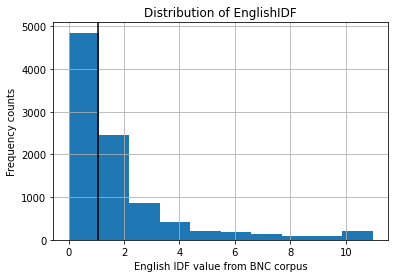

In [ ]:
plt.figure()
plt.title("Distribution of EnglishIDF")
plt.xlabel("English IDF value from BNC corpus")
plt.ylabel("Frequency counts")
q1trainfeatureset2['EnglishIDF'].hist()
plt.axvline(q1trainfeatureset2['EnglishIDF'].median(),color='black')
plt.show()

Imputing:

In [ ]:
medianIDF = q1trainfeatureset2['EnglishIDF'].median()
q1trainfeatureset2.loc[q1trainfeatureset2['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Checking for any null values left post imputing:

In [ ]:
q1trainfeatureset2.isna().sum().sum()

0


Applying the same transformations to the test set lexemes:

In [ ]:
len(q1test_lexemelist)

2776

In [ ]:
# transforming the language column based on already fit one hot encoder:
q1test_lang = pd.DataFrame(enc_lang.transform(np.array(q1testlexemes['learning_language']).reshape(-1, 1)),index=q1testlexemes.index)

# get one hot encoded part of speech:
q1test_pos = pd.DataFrame(enc_pos.transform(np.array(q1testlexemes['pos']).reshape(-1, 1)),index=q1testlexemes.index)


In [ ]:
# explode values of list so a separate record is created for each element of the list. 
q1testlexemes['modstrings'].explode()
#enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1test_mods_exploded =enc_mods.transform(np.array(q1testlexemes['modstrings'].explode()).reshape(-1,1))

q1test_modsdf_exploded = pd.DataFrame(q1test_mods_exploded, index = q1testlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1test_modsdf = q1test_modsdf_exploded.groupby(q1test_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [ ]:
q1test_modsdf.shape, q1testlexemes.shape

((2776, 84), (2776, 317))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [ ]:
q1testfeatureset2 = pd.concat([q1testlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id'] + list(range(0,300))],
                                q1test_lang, 
                                q1test_pos, 
                                q1test_modsdf, 
                                ],axis=1)

In [ ]:
q1testfeatureset2.shape

(2776, 464)

In [ ]:
q1testfeatureset2.columns = q1trainfeatureset2.columns

In [ ]:
# checking for null values 
q1testfeatureset2.isna().sum()

sf_length                    0
L_dist_sf_noaccents_norm     0
EnglishIDF                  55
lexeme_id                    0
0                            0
                            ..
mod_x0_sp                    0
mod_x0_subj                  0
mod_x0_sup                   0
mod_x0_tn                    0
mod_x0_nan                   0
Length: 464, dtype: int64

Imputing the 55 missing values of EnglishIDF with the train set median:

In [ ]:
q1testfeatureset2.loc[q1testfeatureset2['EnglishIDF'].isna(),'EnglishIDF'] = medianIDF

Checking for any null values left post imputing:

In [ ]:
q1testfeatureset2.isna().sum().sum()

0

Saving both feature sets:

In [ ]:
compressed_pickle(path_name+"Q1TRAIN_lexemesFS2",q1trainfeatureset2)
compressed_pickle(path_name+"Q1TEST_lexemesFS2",q1testfeatureset2)

In [ ]:
q1trainfeatureset2 = decompress_pickle(path_name+"Q1TRAIN_lexemesFS2.pbz2")
q1testfeatureset2 = decompress_pickle(path_name+"Q1TEST_lexemesFS2.pbz2")

The number of dimensions matches for train and test post binarizing categorical columns. They are saved as compressed pickle files. 

In [ ]:
q1trainfeatureset2.shape, q1testfeatureset2.shape

((9580, 464), (2776, 464))

Estimate of total size of dataset once joined. 

In [ ]:
(q1trainfeatureset2.size/10**6)/q1trainfeatureset2.shape[0]*q1train.shape[0] + q1train.size/10**6

634.7925349999999

Estimated size is 634 MB

In [ ]:
q1trainfeatureset2.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,lexeme_id,0,1,2,3,4,5,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
7,4,0.5,3.733996,73eecb492ca758ddab5371cf7b5cca32,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,5,0.6,10.981924,c84476c460737d9fb905dca3d35ec995,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,3,0.0,4.051187,1a913f2ded424985b9c02d0436008511,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,5,0.8,0.438409,38b770e66595fea718366523b4f7db3f,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24,3,1.0,0.502649,faa6fd18132b358958e440322ee82b4b,0.129024,0.423030,-0.457697,0.013778,0.316385,0.414319,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Attempts to combine it all at once failed even with high RAM.

```
# getting lexeme id for the full feature set 1
q1trainfeatureset1['lexeme_id'] = q1trainlexemes.loc[q1trainfeatureset1.index,'lexeme_id']

# joining with main dataframe on lexeme id
q1train_withfs1 = pd.merge(left= q1train,right=q1train,left_on='lexeme_id',right_on = 'lexeme_id',how="left")
```

In [ ]:
q1train_X = q1train[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1train_y = q1train['p_forgot_bin']

In [ ]:
# joining with main dataframe on lexeme id
q1train_withfs2 = pd.merge(left= q1train_X,right=q1trainfeatureset2,left_on='lexeme_id',right_on = 'lexeme_id',how="left")

In [ ]:
q1train_withfs2.size/10**6

617.63598

In [ ]:
q1train_withfs2 = q1train_withfs2.drop('lexeme_id',axis=1)

In [ ]:
all_lexemes = pd.DataFrame()
q1trainlexemes = pd.DataFrame()


In [ ]:
q1train_X.shape

(1319735, 5)

In [ ]:
# further reduction


In [ ]:
# # converting to sparse matrix
# from scipy.sparse import coo_matrix, vstack

# count = 0
# step = 100000
# for i in range(0,q1train_X.shape[0],step):
#   if count%2:
#     print(count)
  
#   subdata = q1train_X.iloc[i:min(i+step,q1train_X.shape[0]),:]
#   subdata = pd.merge(left = subdata, right = q1trainfeatureset2,left_on = 'lexeme_id',right_on = 'lexeme_id',how="left")
#   subdata = subdata.drop('lexeme_id',axis=1)
#   #print('size: ',subdata.size/10**6)

#   mat = coo_matrix(subdata)
#   #print('size after compression: ',mat.size/10**6)
#   if i >1:
#     print('stacking: ')
#     Xq1 = vstack([Xq1,mat])
#     #print('saving: ',"Xq1_"+str(count))
#     #compressed_pickle(path_name+"Xq1_"+str(count), mat)
#   else:
#     Xq1 = mat
#     #compressed_pickle(path_name+"Xq1_"+str(count), mat)
#   del subdata, mat
#   count +=1
# #print('Saved all, size Xq1: ',Xq1.size/10**6)
# compressed_pickle(path_name+"q1train_ds1", Xq1)

1
stacking: 
stacking: 
3
stacking: 
stacking: 
5
stacking: 
stacking: 
7
stacking: 
stacking: 
9
stacking: 
stacking: 
11
stacking: 
stacking: 
13
stacking: 


In [ ]:
q1test_X = q1test[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1test_y = q1test['p_forgot_bin']

In [ ]:
q1test_withfs2 = pd.merge(left= q1test_X,right=q1testfeatureset2,left_on='lexeme_id',right_on = 'lexeme_id',how="left")

In [ ]:
#removing lexeme_id
#q1train_withfs2 = q1train_withfs2.drop('lexeme_id',axis=1)
q1test_withfs2 = q1test_withfs2.drop('lexeme_id',axis=1)


In [ ]:
compressed_pickle(path_name+"q1train_X_fs2_ds",q1train_withfs2)
compressed_pickle(path_name+"q1test_X_fs2_ds",q1test_withfs2)

In [ ]:
compressed_pickle(path_name+"q1train_y_fs2_ds",q1test_withfs2)
compressed_pickle(path_name+"q1test_y_fs2_ds",q1train_withfs2)

## PCA


In [ ]:
q1trainfeatureset2 = q1trainfeatureset2.set_index('lexeme_id')
q1testfeatureset2 = q1testfeatureset2.set_index('lexeme_id')

In [ ]:
q1trainfeatureset2.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,6,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
lexeme_id,,,,,,,,,,,,,,,,,,,,,
73eecb492ca758ddab5371cf7b5cca32,4,0.5,3.733996,-0.269015,-0.041727,-0.045045,0.069940,0.067316,0.135177,-0.383724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
c84476c460737d9fb905dca3d35ec995,5,0.6,10.981924,-0.007808,0.188679,-0.264520,-0.134410,0.025235,-0.095146,0.455226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1a913f2ded424985b9c02d0436008511,3,0.0,4.051187,0.820083,0.677704,-0.500191,-0.140807,0.549122,0.634742,-0.355794,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38b770e66595fea718366523b4f7db3f,5,0.8,0.438409,0.020896,0.318951,-0.269169,0.024149,0.415287,0.331545,-0.228645,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
faa6fd18132b358958e440322ee82b4b,3,1.0,0.502649,0.129024,0.423030,-0.457697,0.013778,0.316385,0.414319,0.270645,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Checking for any non-numeric columns left:

In [ ]:
q1trainfeatureset2.select_dtypes('object').columns

Index([], dtype='object')

In [ ]:
q1trainfeatureset2.shape

(9580, 463)

Data is first scaled to make it mean-centered to prepare it for PCA. 

In [ ]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
q1trainfearureset2_ss = stdscaler.fit_transform(q1trainfeatureset2)


from sklearn.decomposition import PCA
pca9 = PCA(n_components=0.9)

# fitting
q1trainfeatureset2_red9 = pca9.fit_transform(q1trainfearureset2_ss)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
q1trainfeatureset2_red9.shape

(9580, 271)

90% variance explained by 271 columns. 

The loadings are investigated below:

In [ ]:
loadings = pd.DataFrame(pca9.components_, columns=q1trainfeatureset2.columns)
loadings

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,0,1,2,3,4,5,6,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
0,0.017849,-0.031132,0.059877,0.030451,-0.078079,0.099147,-0.012676,-0.039878,0.049507,-0.003042,...,-0.018696,-0.004833,-0.003021,0.046398,-0.000822,0.014426,-0.006265,-0.000819,-0.013409,-0.022588
1,0.004827,-0.013681,-0.012546,0.098755,-0.066511,-0.020740,0.084763,-0.051498,-0.012067,-0.040077,...,-0.003618,-0.000626,-0.003140,0.003872,-0.004956,-0.009103,-0.000683,-0.001385,-0.004851,-0.019140
2,0.004775,-0.001418,0.012195,0.047188,0.037138,-0.095112,-0.035519,0.075761,0.054660,-0.003341,...,0.003012,-0.003209,-0.003405,-0.003353,-0.014182,-0.001410,-0.006549,-0.001942,-0.000419,-0.005840
3,-0.052165,0.055742,-0.002425,-0.066930,0.023099,-0.004606,-0.135722,-0.032789,0.084563,0.035475,...,-0.004042,0.015552,0.008573,0.029254,0.015375,0.018216,0.010250,0.002162,0.030015,0.073431
4,-0.059022,0.053721,0.007841,0.097626,0.030037,-0.031822,-0.029534,0.053815,0.022076,0.016516,...,0.005990,0.003328,-0.002332,0.018608,-0.003373,0.002715,0.008244,-0.003924,0.008861,-0.010914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,-0.001649,-0.016163,-0.116243,0.030690,-0.030508,-0.027006,-0.040885,-0.021890,0.018626,-0.109399,...,0.027017,0.026813,0.013161,-0.021365,0.032894,-0.120362,-0.007556,-0.016944,-0.016154,-0.034606
267,0.057014,0.032477,-0.017495,0.051156,0.006122,0.024443,-0.059754,-0.002965,-0.107505,-0.111863,...,-0.003496,-0.019090,0.046365,0.032862,0.070689,-0.073182,0.005049,-0.015593,-0.006549,-0.012985
268,-0.061264,-0.053264,-0.006183,0.069093,0.097740,-0.008988,0.077385,-0.054187,0.019313,0.067915,...,-0.012111,0.006929,0.044115,0.016977,-0.027756,-0.045692,0.008388,0.007976,0.001814,0.049403
269,0.045792,0.042629,0.062948,-0.050038,0.118034,-0.045549,0.007037,0.019161,0.008344,0.059530,...,0.036244,0.031277,0.007650,0.029252,0.080739,-0.055345,-0.011745,-0.022239,-0.008965,-0.026618


In the above dataframe, each row represents a principal component, starting from the directin of highest variance decreasing to the lowest, until 90% of the variance in the original dataset is explained. 

The loadings in each principal component of each feature in the original dataset is summed up in the series below:

In [ ]:
loadingsum = loadings.sum(axis=0)
loadingsum

sf_length                   0.522613
L_dist_sf_noaccents_norm   -0.517891
EnglishIDF                  0.217577
0                           0.659843
1                           0.524927
                              ...   
mod_x0_sp                  -1.594164
mod_x0_subj                 0.882928
mod_x0_sup                  1.692304
mod_x0_tn                   0.695434
mod_x0_nan                  0.448133
Length: 463, dtype: float64

In [ ]:
loadingsum.abs().sort_values(ascending=False).head(20)

mod_x0_@prn:quelque_chose          3.359849
mod_x0_@det:a_le                   3.144091
mod_x0_@subjunctive_perfect        2.857307
pos_x0_vaux                        2.652168
pos_x0_@common_phrases:a_demain    2.595704
mod_x0_pron                        2.436056
pos_x0_@ij:au_revoir               2.172931
mod_x0_@ref                        2.103404
mod_x0_@pos                        2.097157
pos_x0_@adv:a_priori               1.892714
171                                1.852390
pos_x0_@cnj:pendant_que            1.849413
pos_x0_@ij:buenos_dias             1.798597
mod_x0_@prn:quelque_un             1.755661
mod_x0_prn                         1.725476
pos_x0_@cnj:bien_que               1.703490
mod_x0_sup                         1.692304
mod_x0_@prn:le_mien                1.674840
mod_x0_@past_inf                   1.643226
mod_x0_enc                         1.640443
dtype: float64

The components have higher loadings for the part of speech and modifer binary columns, and a few vectr words. 

Derived word vectors don't seem to show too much variance in values in the dataset. 

In [ ]:
pca7 = PCA(n_components=0.7)
# fitting
q1trainfeatureset2_red7 = pca7.fit_transform(q1trainfearureset2_ss)

In [ ]:
q1trainfeatureset2_red7.shape

In [ ]:
q1trainfeatureset2_red9 = pd.DataFrame(q1trainfeatureset2_red9,index=q1trainfeatureset2.index)

In [ ]:
q1trainfeatureset2_red9.shape

In [ ]:
try: 
  del Xq1
except:
  pass

In [ ]:
from scipy.sparse import coo_matrix, vstack
count = 0
step = 300000

array_list = []

for i in range(0,q1train_X.shape[0],step):
  if count%2:
    print(count)
  
  subdata = q1train_X.iloc[i:min(i+step,q1train_X.shape[0]),:]
  subdata = pd.merge(left = subdata, right = q1trainfeatureset2_red9,left_on = 'lexeme_id',right_on = 'lexeme_id',how="left")
  subdata = subdata.drop('lexeme_id',axis=1)
  #print('size: ',subdata.size/10**6)

  mat = coo_matrix(subdata)
  #print('size after compression: ',mat.size/10**6)
  if i >1:
    print('stacking: ')
    array_list = array_list + [mat]
    #print('saving: ',"Xq1_"+str(count))
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  else:
    array_list = [mat]
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  subdata = pd.DataFrame()
  del mat
  count +=1
#print('Saved all, size Xq1: ',Xq1.size/10**6)
#compressed_pickle(path_name+"q1train_pipe1", Xq1)

In [ ]:
Xq1 = vstack(array_list)

In [ ]:
compressed_pickle(path_name+"array_listQ1set2",array_list)

Alternate featureset with just word vectors and derived word features:

In [ ]:
q1trainfeatureset3 = q1trainfeatureset2[[col for col in q1trainfeatureset2 if not (str(col).startswith('mod_') or str(col).startswith('pos_'))]]
q1trainfeatureset3.shape

(9580, 308)

Form the original 466 columns, there are 380 columns left after removing the modifier binary columns. 

PCA is done on this third feature set:

In [ ]:
stdscaler = StandardScaler()
q1trainfearureset3_ss = stdscaler.fit_transform(q1trainfeatureset3)


from sklearn.decomposition import PCA
pca9 = PCA(n_components=100)

# fitting
q1trainfeatureset3_red9 = pca9.fit_transform(q1trainfearureset3_ss)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
q1trainfeatureset3_red9.shape

(9580, 100)

In [ ]:
pca9.explained_variance_ratio_

array([0.06619405, 0.05147106, 0.03919054, 0.03348598, 0.02658008,
       0.02600953, 0.02165031, 0.02070371, 0.01886798, 0.01763809,
       0.0159359 , 0.01584384, 0.0138158 , 0.01361024, 0.0123509 ,
       0.01163668, 0.01153234, 0.01081242, 0.01049186, 0.00976742,
       0.00953944, 0.00950598, 0.00923594, 0.00826866, 0.00808587,
       0.00781048, 0.0075957 , 0.00747869, 0.00728891, 0.00701328,
       0.00687421, 0.00646754, 0.0063799 , 0.00607767, 0.00591149,
       0.0057029 , 0.00559362, 0.00549643, 0.00534206, 0.00524224,
       0.0052056 , 0.00507495, 0.00499509, 0.00483487, 0.0047755 ,
       0.00471447, 0.00463136, 0.00455475, 0.00445478, 0.00438062,
       0.00431176, 0.00424635, 0.00416071, 0.00410891, 0.00402671,
       0.00398424, 0.0039322 , 0.00387728, 0.00379481, 0.0037498 ,
       0.00371037, 0.00367887, 0.00363707, 0.00352961, 0.00348647,
       0.00334931, 0.00333054, 0.00325821, 0.00322166, 0.00320747,
       0.00314034, 0.00312089, 0.00311576, 0.00302583, 0.00297



Looking at the loadings:

In [ ]:
loading_first_component = pd.DataFrame(pca9.components_[0],index=q1trainfeatureset3.columns)
loading_first_component


,0
sf_length,0.017220
L_dist_sf_noaccents_norm,-0.029503
EnglishIDF,0.062207
0,0.028653
1,-0.078596
...,...
lang_x0_en,0.005167
lang_x0_es,0.007362
lang_x0_fr,0.000886
lang_x0_it,-0.005197


Loadings of language column in first component:

In [ ]:
loading_first_component.loc[[ind for ind in loading_first_component.index if str(ind).startswith('lang_')],:]

,0
lang_x0_en,0.005167
lang_x0_es,0.007362
lang_x0_fr,0.000886
lang_x0_it,-0.005197
lang_x0_pt,-0.010906


Loadings of word vectors in first component:

In [ ]:
loading_first_component.loc[[ind for ind in loading_first_component.index if type(ind)==int],:]

,0
0,0.028653
1,-0.078596
2,0.101917
3,-0.016131
4,-0.039298
...,...
295,-0.003118
296,0.094454
297,0.020516
298,-0.122143


In [ ]:
loading_first_component.loc[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm'],:]

,0
EnglishIDF,0.062207
sf_length,0.017220
L_dist_sf_noaccents_norm,-0.029503


It appears that just the word vectors are being represented. 

We will reduce just the word vectors to around 50 columns, and combined with the derived word features of IDF, levenshtein and word length, for the second featureset. 

In [ ]:
q1train_vectors_only = q1trainfeatureset2[[col for col in q1trainfeatureset2.columns if type(col)==int]]

In [ ]:
q1train_vectors_only.shape

(9580, 300)

PCA to reduce to 20 components.

In [ ]:
from sklearn.preprocessing import StandardScaler
stdscaler_ = StandardScaler()
q1train_vectors_only_ss = stdscaler_.fit_transform(q1train_vectors_only)


from sklearn.decomposition import PCA
pca_vectors_only = PCA(n_components=20)

# fitting
q1train_vecs = pca_vectors_only.fit_transform(q1train_vectors_only_ss)
q1train_vecs = pd.DataFrame(q1train_vecs,index=q1train_vectors_only.index)
q1train_vecs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
lexeme_id,,,,,,,,,,,,,,,,,,,,
73eecb492ca758ddab5371cf7b5cca32,-0.452710,-0.558236,-0.639567,2.269826,-0.844804,0.175355,-0.576253,-1.668955,-0.453624,-0.374955,0.342216,0.617846,-0.378276,-2.656673,0.123361,0.696359,-1.884635,-0.708624,0.737728,-0.489549
c84476c460737d9fb905dca3d35ec995,2.611754,-1.571788,-0.504870,-1.644202,0.576935,-1.323444,4.898269,-0.849353,1.268854,1.735331,-2.129070,0.589688,0.861232,0.271718,-2.195074,0.851241,1.552951,0.351710,-0.898086,-0.269394
1a913f2ded424985b9c02d0436008511,-0.675037,-7.008998,1.839328,-0.117723,1.347551,-10.244642,-3.146619,4.500447,3.091799,5.076135,4.141311,-5.518284,1.471674,-1.202059,3.441252,-0.464350,-1.766045,-0.721544,-3.276126,0.021318
38b770e66595fea718366523b4f7db3f,-0.494681,4.057475,2.285355,2.261522,0.946912,-0.062971,-1.538923,3.194151,-0.078913,2.396988,0.378433,-2.428070,1.231027,0.269840,-1.034426,-3.267227,-1.955547,-0.509287,-0.158977,-0.067786
faa6fd18132b358958e440322ee82b4b,3.266690,-0.605462,6.796345,0.834556,-1.375737,2.578764,-1.538290,2.527200,1.230444,-1.144847,-2.011828,-2.615437,-1.076162,-0.307319,1.785026,-1.426639,-2.087948,-1.746518,-0.009074,-2.009065


In [ ]:
pca_vectors_only.explained_variance_ratio_.sum()

0.4563050658934774

In [ ]:
loadings = pd.DataFrame(pca_vectors_only.components_.transpose())
loadings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.028688,0.100457,0.041576,-0.071745,0.048934,-0.086737,-0.103661,0.046037,-0.047956,0.040752,0.065820,0.016182,-0.019185,-0.020744,-0.008045,0.024158,0.052381,-0.049748,0.039291,0.030017
1,-0.078703,-0.072907,0.034396,0.025292,0.048342,-0.001445,0.012993,0.090825,-0.085591,0.102866,-0.009495,-0.009216,-0.091719,0.054395,0.016732,-0.030888,0.046880,0.036618,-0.031555,-0.087997
2,0.102143,-0.014828,-0.094963,0.005723,-0.025079,0.023153,-0.014135,-0.087200,-0.085106,0.053554,0.055205,-0.018110,0.030817,-0.009903,0.029610,-0.122325,0.017762,0.061573,0.069630,-0.000047
3,-0.016092,0.082499,-0.043867,-0.137609,0.036199,0.085526,-0.078095,0.012945,0.052840,-0.036314,-0.060911,-0.038786,-0.079751,-0.028616,-0.063006,-0.042116,-0.042627,0.027509,-0.078804,0.066240
4,-0.039243,-0.055648,0.069908,-0.039631,0.090605,0.005984,-0.015561,0.068456,-0.042021,0.067245,-0.018152,-0.013696,0.073973,-0.117003,0.033176,-0.026485,0.016812,-0.080728,0.039345,-0.008810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.003075,-0.003663,0.033907,0.027174,0.009939,-0.022491,0.071134,0.010774,-0.009228,-0.041871,0.046954,-0.039964,-0.014544,-0.056660,-0.047519,0.122072,0.052829,-0.016683,-0.021625,0.045069
296,0.094760,0.012866,0.004324,-0.055517,0.047887,-0.097561,0.023385,0.005466,0.095201,-0.087048,-0.027784,0.001976,-0.019340,-0.077203,0.027793,-0.071054,-0.113176,-0.053646,-0.054202,0.037154
297,0.020603,0.071122,0.002992,-0.084274,-0.050928,-0.136766,-0.098724,0.092433,0.003288,0.010120,-0.016107,-0.010626,-0.106281,-0.065732,-0.099243,0.071138,0.016909,0.006055,0.034912,0.000730
298,-0.122520,-0.045790,-0.062905,0.022588,0.020135,-0.020824,0.082470,-0.066310,0.076385,-0.025696,0.035636,0.020276,0.002360,-0.046128,0.032278,-0.003660,-0.051688,0.028090,-0.015415,-0.013648


Dropping extraneous columns from q1train, and q1trainfeatureset1

In [ ]:
q1trainfeatureset4 = pd.merge(left = q1trainfeatureset2[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']],right=q1train_vecs,how="left",right_index=True, left_index=True)

In [ ]:
q1trainfeatureset4.shape

(9580, 23)

The columns needed for merging with lexemes for q1train_X: delta, lexeme_id, history_seen, history_frac, simoverdiff, 

The columns needed for q1train_y: p_forgot_bin


In [ ]:
q1train_X = q1train[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1train_y = q1train['p_forgot_bin']

In [ ]:
q1train_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')

In [ ]:
q1train_X.isna().sum()

lexeme_id       0
delta           0
history_seen    0
history_frac    0
simoverdiff     0
dtype: int64

All other non-numerical columns have been dropped. 

Merging q1train_X and q1trainfeatureset4

In [ ]:
q1train_X4 = pd.merge(left = q1train_X,right=q1trainfeatureset4,how="left",left_on = 'lexeme_id',right_index=True)

In [ ]:
q1train_X4.shape

(1319735, 28)

Combining test set similarly:

In [ ]:
q1test_vectors_only = q1testfeatureset2[[col for col in q1testfeatureset2.columns if type(col)==int]]

In [ ]:
q1test_vectors_only.shape

(2776, 300)

In [ ]:
# transform with std scaler and PCA

q1test_vectors_only_ss = stdscaler_.transform(q1test_vectors_only)

q1test_vecs = pca_vectors_only.transform(q1test_vectors_only_ss)
q1test_vecs = pd.DataFrame(q1test_vecs,index=q1test_vectors_only.index)
q1test_vecs.head()

In [ ]:
q1testfeatureset4 = pd.merge(left = q1testfeatureset2[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']],right=q1test_vecs,how="left",right_index=True, left_index=True)

In [ ]:
q1testfeatureset4.shape

In [ ]:
q1testfeatureset4

The columns needed for merging with lexemes for q1train_X: delta, lexeme_id, history_seen, history_frac, simoverdiff, 

The columns needed for q1train_y: p_forgot_bin


In [ ]:
q1test_X = q1test[['lexeme_id','delta','history_seen','history_frac','simoverdiff',]]

q1test_y = q1test['p_forgot_bin']

In [ ]:
q1test_X.columns

In [ ]:
q1test_X.isna().sum()

All other non-numerical columns have been dropped. 

Merging q1train_X and q1trainfeatureset4

In [ ]:
q1testfeatureset4.head()

In [ ]:
q1test_X4 = pd.merge(left = q1test_X,right=q1testfeatureset4,how="left",left_on = 'lexeme_id',right_index=True)

In [ ]:
q1test_X4.shape

In [ ]:
compressed_pickle(path_name+"Q1TRAIN_pipe4",q1train_X4)
compressed_pickle(path_name+"Q1TEST_pipe4",q1test_X4)

compressed_pickle(path_name+"Q1TRAIN_Y_pipe4",q1train_y)
compressed_pickle(path_name+"Q1TEST_Y_pipe4",q1test_y)


In [ ]:
compressed_pickle(path_name+"q1fs4_column_names",q1trainfeatureset4.columns)

In [ ]:
q1train_X4.size/10**6, q1test_X4.size/10**6

## <font color = 'cornflowerblue' size=4>Conclusions and Next Steps</font>

Word based features have been joined to the Q1 train and test dataframes, and stored as compressed sparse matrices. 

scaling will be done before modeling. 

Next steps:

For pipe1:

Further split q1train_featureset1 into training and validation sets (90-10) split. 

1. Model with classical machine learning techniques
- downsample or upsample or adjust class weight hyperparameter
- logistic regression
- decision tree
- Naive Bayes classification
- downsampled kNN
- doensampled SVM

2. Ensemble techniques
- Random Forest
- AdaBoost
- XGBoost

3. Neural net
- Dense neural net. 

Model performance of pipe1 will be compared with validation set performance average precision and ROC AUC, with a baseline model with no word based features. 

